In [1]:
%load_ext autoreload
%autoreload 2
import dill
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from os import listdir
from os.path import isfile, join
from sorcery import dict_of
import pprint
import IPython

2024-08-16 23:30:48,515 [INFO ]  

>>>>> start execution


In [3]:
# scan results folder, default values for figures
# only show results from this "frozen" folder
results_dir = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"]).parent
files = [
    f
    for f in listdir(results_dir)
    if isfile(join(results_dir, f)) and f.endswith(".pic")
]
files.sort()
selected_files = []

ax = None

plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (6, 3)

In [4]:
def draw_rate_vs_angle(data, filename, show_lso=True, show_mso=True):
    angle_to_rate = data["angle_to_rate"]
    name = data["conf"]["model_desc"]["name"]
    sound_key = data["conf"]["sound_key"]
    # cochlea = data["conf"]["cochlea_type"]

    angles = list(angle_to_rate.keys())

    def average_firing_rate(x):
        active_neurons = set(x)
        return (
            (len(x["times"]) / len(active_neurons)) if len(active_neurons) >= 0 else 0
        )

    arr_n_spikes_r_lso = [
        average_firing_rate(x["R"]["LSO"]) for angle, x in angle_to_rate.items()
    ]
    arr_n_spikes_l_lso = [
        average_firing_rate(x["L"]["LSO"]) for angle, x in angle_to_rate.items()
    ]
    arr_n_spikes_r_mso = [
        average_firing_rate(x["R"]["MSO"]) for angle, x in angle_to_rate.items()
    ]
    arr_n_spikes_l_mso = [
        average_firing_rate(x["L"]["MSO"]) for angle, x in angle_to_rate.items()
    ]

    lso = {
        "spikes": [arr_n_spikes_r_lso, arr_n_spikes_l_lso],
        "show": show_lso,
        "label": "lso",
    }
    mso = {
        "spikes": [arr_n_spikes_r_mso, arr_n_spikes_l_mso],
        "show": show_mso,
        "label": "mso",
    }
    data = []
    for i in [lso, mso]:
        if i["show"]:
            data.append(i)
    num_subplots = len(data)
    fig, ax = plt.subplots(num_subplots, figsize=(8, 2 * num_subplots))
    if type(ax) is not np.ndarray:
        ax = [ax]
    for axis, d in zip(ax, data):
        axis.plot(angles, d["spikes"][0], ".-", label=f"right {d["label"]}")
        axis.plot(angles, d["spikes"][1], ".-", label=f"left {d["label"]}")
        axis.set_ylabel("avg spk/sec (Hz)")
        _ = axis.legend()
    # fig.suptitle(f"{name} with {sound_key}")
    plt.suptitle(filename)
    plt.setp([ax], xticks=angles)

    plt.tight_layout()
    plt.show()
    return fig

In [5]:
def show_stats(data, lso, mso):
    total_spikes_R_LSO = sum(
        [len(x["R"]["LSO"]["times"]) for angle, x in data["angle_to_rate"].items()]
    )
    total_spikes_L_LSO = sum(
        [len(x["L"]["LSO"]["times"]) for angle, x in data["angle_to_rate"].items()]
    )
    total_spikes_R_MSO = sum(
        [len(x["R"]["MSO"]["times"]) for angle, x in data["angle_to_rate"].items()]
    )
    total_spikes_L_MSO = sum(
        [len(x["L"]["MSO"]["times"]) for angle, x in data["angle_to_rate"].items()]
    )
    print(
        dict_of(
            total_spikes_R_LSO,
            total_spikes_L_LSO,
            total_spikes_R_MSO,
            total_spikes_L_MSO,
        )
    )

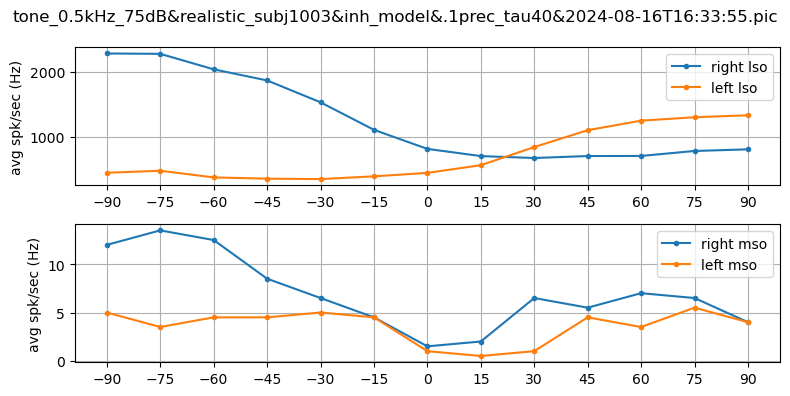

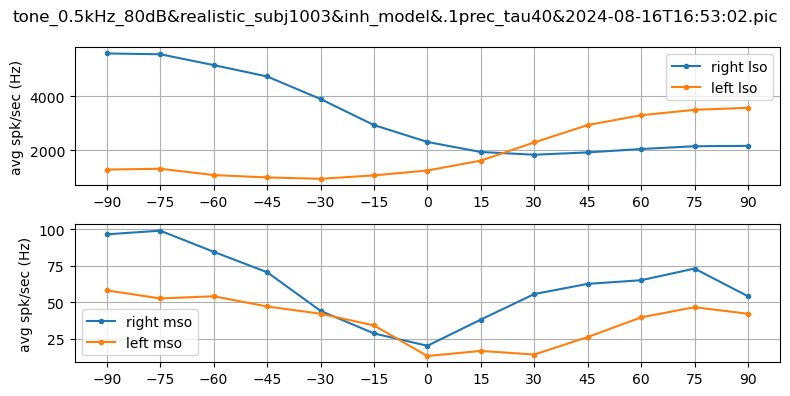

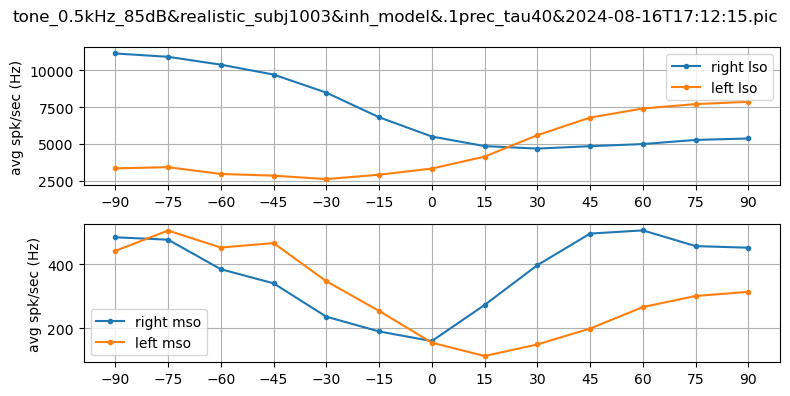

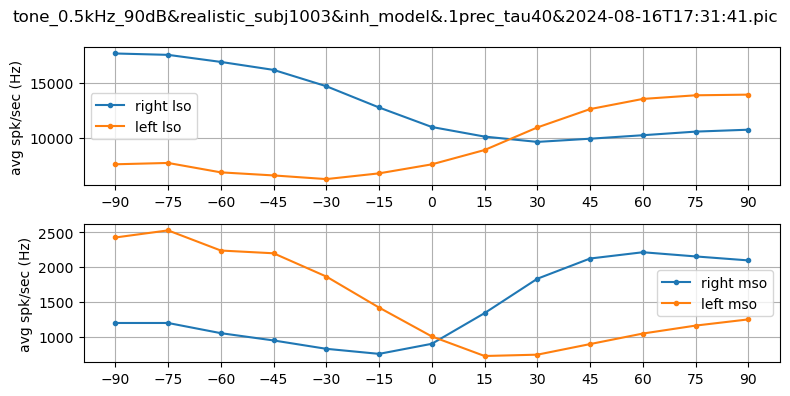

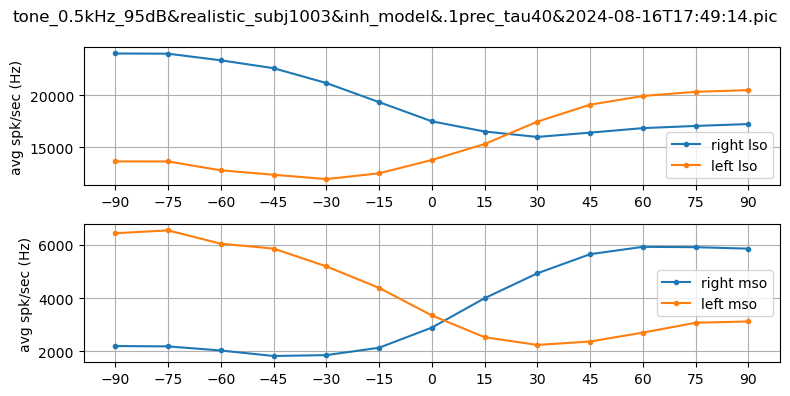

In [6]:
for selected in files:
    with open(join(results_dir, selected), "rb") as f:
        res = dill.load(f, ignore=True)
        fig = draw_rate_vs_angle(res, selected, True, True)


def show_selected_info(selected):
    res = dill.load(f, ignore=True)
    # print(type(res['conf']['parameters']))
    print(
        f"""\
name  : {res['conf']['model_desc']['name']}
sndkey: {res['conf']['sound_key']}
coctyp: {res['conf']['cochlea_type']}
params: {pprint.pformat(res['conf']['parameters'], width=10, sort_dicts=False)}"""
    )